In [78]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/s3/0yt2kl_551b7nh0_73s9j0nw0000gn/T/pip-req-build-5em_u9fy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/s3/0yt2kl_551b7nh0_73s9j0nw0000gn/T/pip-req-build-5em_u9fy
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done


In [86]:
# Import packages
import numpy as np
import torch
import clip
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
from pkg_resources import packaging
from torchvision.datasets import CIFAR100

### Loading the Model

In [7]:
# Show available CLIP models
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [79]:
# Load CLIP model
model, preprocess = clip.load("ViT-B/32")
# Call .eval() to set dropout and batchnorm layers to evaluation mode before running inference
model.eval()
# Resolution of input image into model
input_resolution = model.visual.input_resolution
# Prompt size; has been padded to take 77 tokens
context_length = model.context_length
# Vocabulary size of model
vocab_size = model.vocab_size

# Print input resolution, context length and vocabulary size of model
print("Input Resolution:", input_resolution)
print("Context Length:", context_length)
print("Vocabulary Size:", vocab_size)

Input Resolution: 224
Context Length: 77
Vocabulary Size: 49408


### Image Preprocessing
Resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, normalize the pixel intensity using the dataset mean and standard deviation. The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.

In [12]:
# Run preprocess command
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fb34b301c10>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

### Text Preprocessing
We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [221]:
# Example of a tokenized prompt
clip.tokenize("shrek is love, shrek is life")

tensor([[49406, 35009,   533,   793,   267, 35009,   533,   970, 49407,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

### Setting Up Input Images and Texts
Feed image exmaples and their textual descriptions to the model, and compare their similarity between the corresponding features. The tokenizer is case-insensitive, and we can freely give any suitable textual description

In [288]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Image to use and its textual description
description = {"apple": "This is a photo of an apple"}

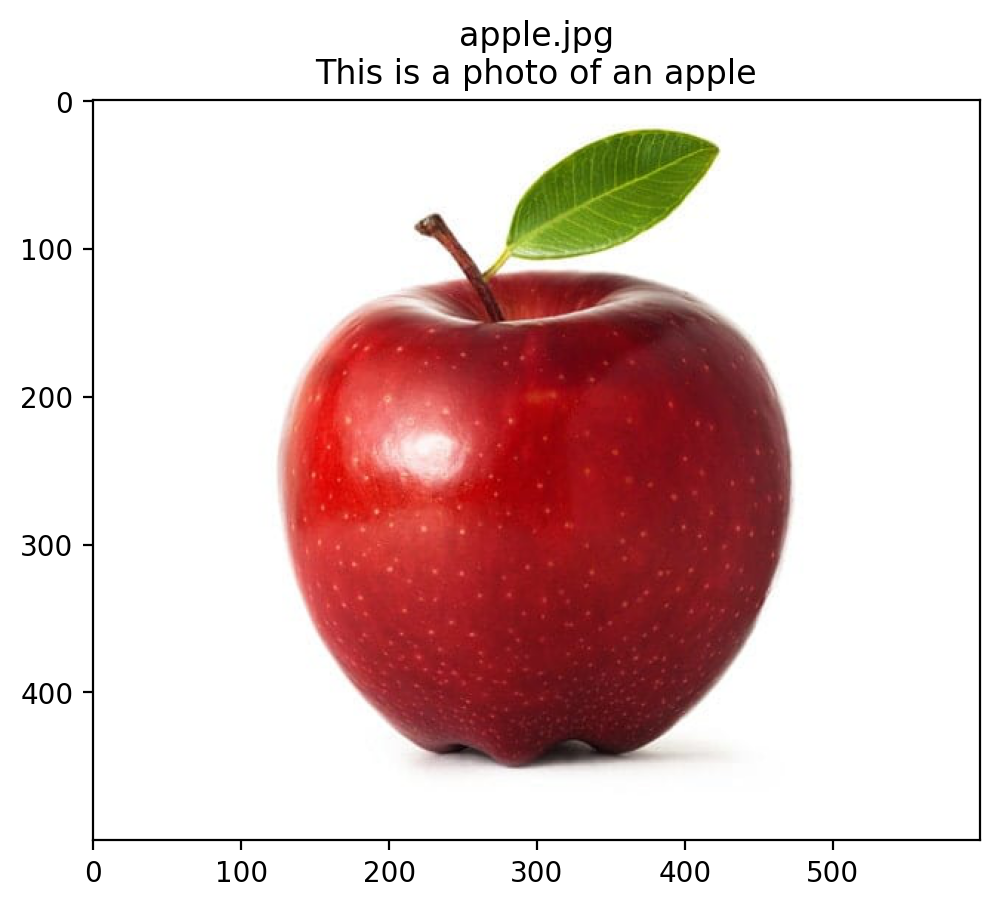

In [289]:
# Initialze arrays containing original image, preprocessed image and associate text
original_image = []
preprocessed_image = []
text = []

# Define path to where image is located
path = "/Users/rnaik/Downloads"

# Collect file name of image in path
for filename in [filename for filename in os.listdir(path) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in description:
        continue
    # Open image    
    image = Image.open(os.path.join(path, filename)).convert("RGB")

# Print image in notebook with title as the file name and associated description
plt.imshow(image)
plt.title(f"{filename}\n{description[name]}")

# Append original image, preprocessed image and text arrays with image, preprocessed image and description
original_image.append(image)
preprocessed_image.append(preprocess(image))
text.append(description[name])

### Building Features
Normalize the image, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [300]:
image_input = torch.tensor(np.stack(preprocessed_image))

In [301]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

### Calculate Cosine Similarity
Normalize the features and calculate the dot product of image-text pair.

In [302]:
# Normal image features
image_features /= image_features.norm(dim = -1, keepdim = True)
# Normalize text features
text_features /= text_features.norm(dim = -1, keepdim = True)
# Caclulate similarity score of image-text pair
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

### Zero-Shot Image Classification
Classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [303]:
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


In [304]:
text_description = [f"A photo of {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_description)

In [305]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim = -1, keepdim = True)

# Calculate probability of each classification label using softmax function
text_probs = (100.0 * image_features @ text_features.T).softmax(dim = -1)

top_probs, top_labels = text_probs.cpu().topk(50, dim = -1)
top_labels = [cifar100.classes[index] for index in np.array(top_labels[0])]

print(top_prob, top_labels)

tensor([[9.6742e-01, 1.5705e-02, 3.0886e-03, 1.9795e-03, 1.5006e-03, 1.1824e-03,
         9.1800e-04, 6.9426e-04, 5.9162e-04, 4.0306e-04, 3.9413e-04, 3.3441e-04,
         3.1752e-04, 2.5529e-04, 2.4693e-04, 2.4322e-04, 2.3591e-04, 2.3007e-04,
         2.2693e-04, 2.0979e-04, 2.0777e-04, 1.9036e-04, 1.7176e-04, 1.5193e-04,
         1.3863e-04, 1.3386e-04, 1.3356e-04, 1.3067e-04, 1.1953e-04, 1.1755e-04,
         1.1436e-04, 1.1229e-04, 9.7549e-05, 9.6645e-05, 9.6555e-05, 9.5229e-05,
         9.0996e-05, 9.0780e-05, 8.8394e-05, 7.5261e-05, 7.3630e-05, 6.9800e-05,
         6.7013e-05, 6.3811e-05, 6.0722e-05, 5.7260e-05, 5.1252e-05, 4.7822e-05,
         4.6064e-05, 4.5142e-05]]) ['apple', 'pear', 'plain', 'orange', 'streetcar', 'maple_tree', 'oak_tree', 'rose', 'can', 'sweet_pepper', 'bowl', 'skunk', 'trout', 'cup', 'pine_tree', 'bee', 'cockroach', 'tulip', 'telephone', 'willow_tree', 'snake', 'baby', 'crab', 'worm', 'poppy', 'tractor', 'wolf', 'spider', 'plate', 'table', 'man', 'tank', 'fo